# DoWhy Causal Inference Example

Much like machine learning libraries have done for prediction, “DoWhy” is a Python library that aims to spark causal thinking and analysis. DoWhy provides a principled four-step interface for causal inference that focuses on explicitly modeling causal assumptions and validating them as much as possible. The key feature of DoWhy is its state-of-the-art refutation API that can automatically test causal assumptions for any estimation method, thus making inference more robust and accessible to non-experts. DoWhy supports estimation of the average causal effect for backdoor, frontdoor, instrumental variable and other identification methods, and estimation of the conditional effect (CATE) through an integration with the EconML library.

Predictive models uncover patterns that connect the inputs and outcome in observed data. To intervene, however, we need to estimate the effect of changing an input from its current value, for which no data exists. Such questions, involving estimating a counterfactual, are common in decision-making scenarios.

See the [DoWhy](https://www.pywhy.org/dowhy/v0.8/getting_started/intro.html) documentation for more details.

In [1]:
# setup of packages

import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

In [2]:
# simulate some input data

data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=5000,
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3 W4     v0  \
0  0.425355  0.0  0.803149  0.941330 -0.385764  1.257649 -0.006678  3   True   
1 -0.335679  0.0  0.787822  0.666777 -2.153988 -0.828340  0.795762  2   True   
2  0.641379  0.0  0.309725 -1.192469 -1.245117  0.326909  1.797703  0  False   
3  1.160370  0.0  0.756346 -1.681194  0.823240  1.227875  1.543800  3   True   
4  0.765113  0.0  0.464143 -0.391589 -1.266485  0.822307 -0.507543  0  False   

           y  
0  13.202436  
1  11.949498  
2   2.764710  
3  15.520589  
4  -5.016181  
digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] 

## Interface 1 (the recommended way): Input causal graph

In [3]:
# display as a graph

model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

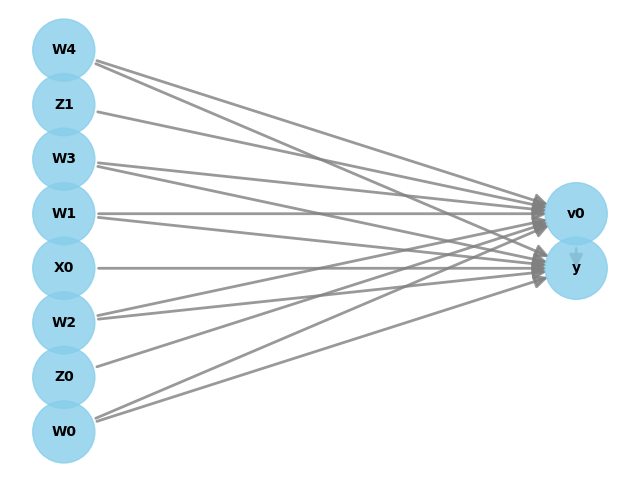

In [4]:
model.view_model()

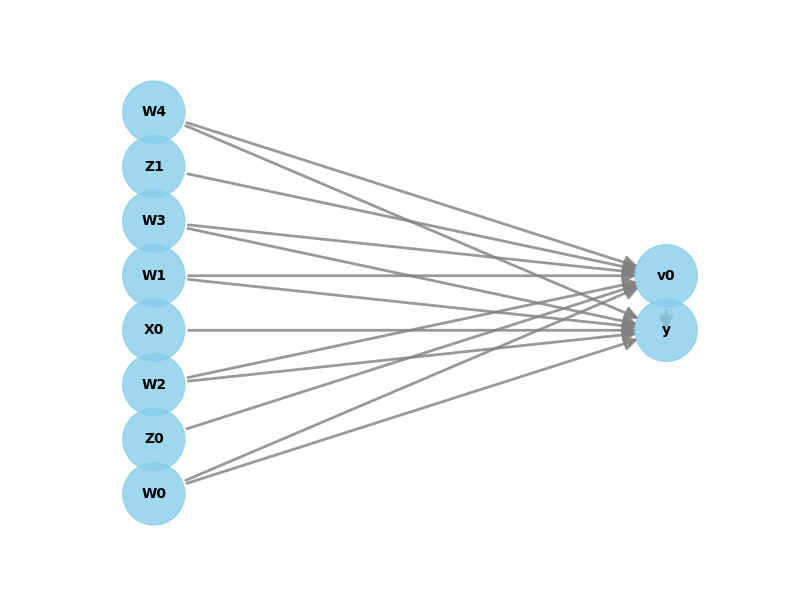

In [5]:
# display the image generated in a generic way

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
# identification

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W1,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W1,W3,W4,U) = P(y|v0,W0,W2,W1,W3,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
# estimation

causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W1,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W1,W3,W4,U) = P(y|v0,W0,W2,W1,W3,W4)

## Realized estimand
b: y~v0+W0+W2+W1+W3+W4
Target units: ate

## Estimate
Mean value: 10.418611933626892

Causal Estimate is 10.418611933626892


In [8]:
# Causal effect on the control group (ATC)

causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W1,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W1,W3,W4,U) = P(y|v0,W0,W2,W1,W3,W4)

## Realized estimand
b: y~v0+W0+W2+W1+W3+W4
Target units: atc

## Estimate
Mean value: 10.482914338498723

Causal Estimate is 10.482914338498723


## Interface 2: Specify common causes and instruments

In [9]:
# Without graph

model= CausalModel(
        data=df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"])

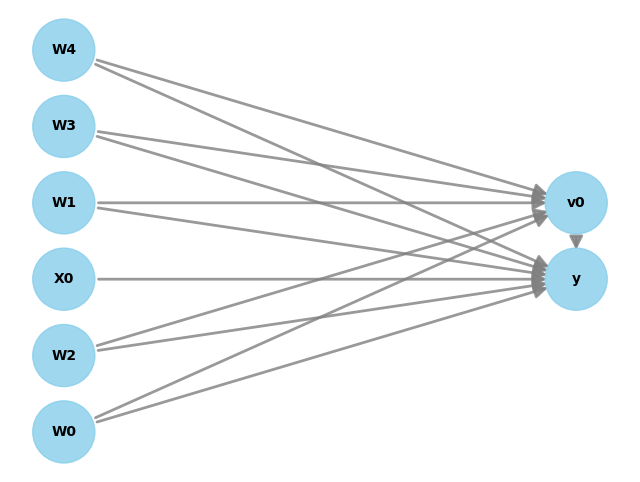

In [10]:
model.view_model()

In [12]:
# DoWhy constructed a graph, it can now used as before

# identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [13]:
# estimation
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W1,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W1,W3,W4,U) = P(y|v0,W0,W2,W1,W3,W4)

## Realized estimand
b: y~v0+W0+W2+W1+W3+W4
Target units: ate

## Estimate
Mean value: 10.418611933626892

Causal Estimate is 10.418611933626892


## Refuting the estimate

In [14]:
# add a random common cause variable
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:10.418611933626892
New effect:10.41861193362689
p value:1.0



In [15]:
# replace treatment with random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:10.418611933626892
New effect:0.004329899794331305
p value:0.94



In [16]:
# remove a random subset of the data
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.418611933626892
New effect:10.413532503265712
p value:0.9



In [17]:
# propensity score stratification estimator with random_seed parameter added
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.418611933626892
New effect:10.422770774591106
p value:0.96



## Adding an unobserved common cause variable

In [18]:
res_unobserved=model.refute_estimate(
    identified_estimand, estimate, method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:10.418611933626892
New effect:10.060825773483808



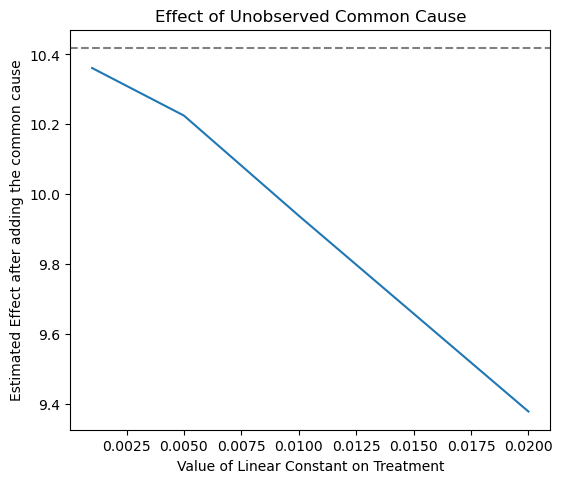

Refute: Add an Unobserved Common Cause
Estimated effect:10.418611933626892
New effect:(9.3773013648896, 10.361026826648361)



In [20]:
res_unobserved_range=model.refute_estimate(
    identified_estimand, estimate, method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=np.array([0.001, 0.005, 0.01, 0.02]), effect_strength_on_outcome=0.01
)
print(res_unobserved_range)

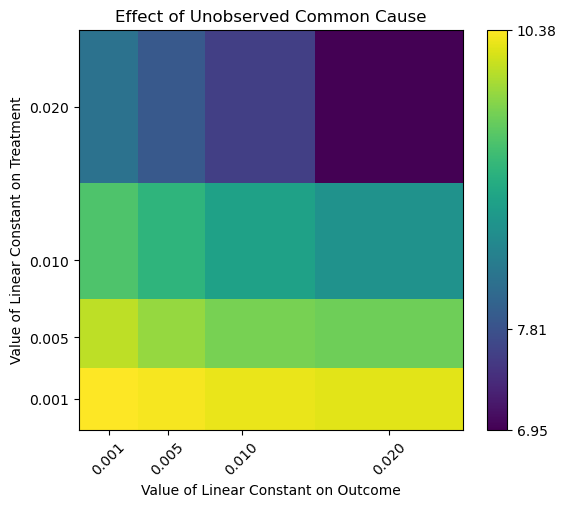

Refute: Add an Unobserved Common Cause
Estimated effect:10.418611933626892
New effect:(6.950561102118742, 10.381567416361133)



In [21]:
res_unobserved_range=model.refute_estimate(
    identified_estimand, estimate, method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=[0.001, 0.005, 0.01, 0.02],
    effect_strength_on_outcome=[0.001, 0.005, 0.01,0.02]
)
print(res_unobserved_range)

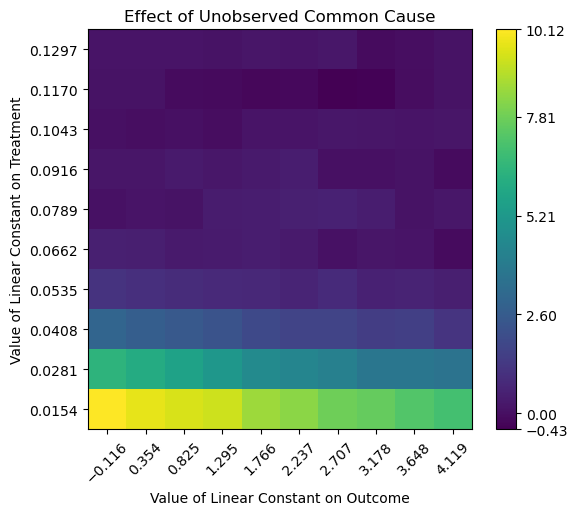

Refute: Add an Unobserved Common Cause
Estimated effect:10.418611933626892
New effect:(-0.4281272772939085, 10.123197670774196)



In [22]:
# automatically inferring effect strength parameters
res_unobserved_auto = model.refute_estimate(
    identified_estimand, estimate, method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear"
)
print(res_unobserved_auto)